# Train Model by country

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from tqdm.auto import tqdm

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# set the font size for matplotlib and the font family.
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [2]:
# load the necessary functions from the analysis package

# load the variable names, this allows to access the variables in the feature data in a compact way
from analysis_utils.variable_names import *

# load flagged ids 
from analysis_utils.flagged_uids import *

# load the functions to do spatial k-fold CV
from analysis_utils.spatial_CV import *

# load the helper functions
from analysis_utils.analysis_helpers import *

# load the random forest trainer and cross_validator
import analysis_utils.RandomForest as rf

# load the combien model
from analysis_utils.CombinedModel import CombinedModel

In [3]:
# set the global file paths
root_data_dir = "../../Data"

# the lsms data
lsms_pth = f"{root_data_dir}/lsms/processed/labels_cluster_v1.csv"

# the feature data
feat_data_pth = f"{root_data_dir}/feature_data/tabular_data.csv"

# set the random seed
random_seed = 423
spatial_cv_random_seed = 348

# set the number of folds for k-fold CV
n_folds = 5

In [4]:
# load the feature and the label data
lsms_df = pd.read_csv(lsms_pth)

# remove flagged ids form dataset
lsms_df = lsms_df[~lsms_df.unique_id.isin(flagged_uids)].reset_index(drop = True)

# create average varaibles for the between model
lsms_df['avg_log_mean_pc_cons_usd_2017'] = lsms_df.groupby('cluster_id')['log_mean_pc_cons_usd_2017'].transform('mean')
lsms_df['avg_mean_asset_index_yeh'] = lsms_df.groupby('cluster_id')['mean_asset_index_yeh'].transform('mean')

# load the feature data
feat_df = pd.read_csv(feat_data_pth)

# describe the training data broadly
print(f"Number of observations {len(lsms_df)}")
print(f"Number of clusters {len(np.unique(lsms_df.cluster_id))}")
print(f"Number of x vars {len(feat_df.columns)-2}")

Number of observations 6401
Number of clusters 2128
Number of x vars 113


In [5]:
# merge the label and the feature data to one dataset
lsms_vars = ['unique_id','n_households', 'country', 'lat', 'lon',        
             'log_mean_pc_cons_usd_2017', 'avg_log_mean_pc_cons_usd_2017',
             'mean_asset_index_yeh', 'avg_mean_asset_index_yeh']
df = pd.merge(lsms_df[lsms_vars], feat_df, on = 'unique_id', how = 'left')

In [6]:
# define the x variables and the target variable for the between and within models

# define the between variables
avg_rs_vars = avg_ndvi_vars + avg_ndwi_gao_vars + avg_nl_vars
osm_vars = osm_dist_vars + osm_count_vars + osm_road_vars
between_x_vars = osm_vars + esa_lc_vars + wsf_vars + avg_rs_vars + avg_preciptiation + median_rgb_vars 
between_target_var = 'avg_log_mean_pc_cons_usd_2017'

# define the within varaibles
dyn_rs_vars = dyn_ndvi_vars + dyn_ndwi_gao_vars + dyn_nl_vars
within_x_vars = dyn_rs_vars + precipitation + dyn_rgb_vars
within_target_var = 'log_mean_pc_cons_usd_2017'

In [7]:
# define the between and the within df

between_df = df[['cluster_id', 'country', between_target_var] + between_x_vars].drop_duplicates().reset_index(drop = True)
within_df = df[['unique_id', 'cluster_id', 'country',within_target_var] + within_x_vars]

# Run the CV

In [8]:
# train a model on each country and evaluate on the remaining countries.
# for the country itself, use spatial cross validation to evaluate the model

In [9]:
countries = ['eth', 'mwi', 'nga', 'tza', 'uga']
cross_cntry_res = {}

between_df_norm = standardise_df(between_df, exclude_cols = [between_target_var])
demeaned_df_norm = standardise_df(demean_df(within_df), exclude_cols = [within_target_var])
demeaned_df_norm['country'] = within_df['country']

for cntry in tqdm(countries):
    
    # subset the training data
    train_between_df_norm = between_df_norm[between_df_norm.country == cntry].reset_index(drop = True)
    train_demeaned_df_norm = demeaned_df_norm[demeaned_df_norm.country == cntry].reset_index(drop = True)
    
    # get the X and y vectors
    X_train_between = train_between_df_norm.loc[:, between_x_vars]
    y_train_between = np.array(train_between_df_norm[[between_target_var]]).ravel()
    
    X_train_within = train_demeaned_df_norm.loc[:, within_x_vars]
    y_train_within = np.array(train_demeaned_df_norm[[within_target_var]]).ravel()
    
    # train the between model
    between_rf = rf.Trainer(X_train_between, y_train_between, None, None, random_seed)
    between_rf.train(min_samples_leaf = 1)
    
    # train within model
    within_rf = rf.Trainer(X_train_within, y_train_within, None, None, random_seed)
    within_rf.train(min_samples_leaf = 1)
    
    # evaluate the between and the within models on all other countries
    val_countries = [i for i in countries if i != cntry]
    
    # define object to store results of country
    cross_cntry_res[cntry] = {
        'between_r2': [],
        'within_r2': [], 
        'overall_r2': [],
        'val_cntry': []
    }
    
    for val_cntry in val_countries:
        
        # subset the data to the validation country
        val_df = df.loc[df.country == val_cntry].reset_index(drop = True)
        
        # normalise data
        val_between_df_norm = between_df_norm[between_df_norm.country == val_cntry].reset_index(drop = True)
        val_demeaned_df_norm = demeaned_df_norm[demeaned_df_norm.country == val_cntry].reset_index(drop = True)
    
        # get the X and y vectors
        X_val_between = val_between_df_norm.loc[:, between_x_vars]
        y_val_between = np.array(val_between_df_norm[[between_target_var]]).ravel()

        X_val_within = val_demeaned_df_norm.loc[:, within_x_vars]
        y_val_within = np.array(val_demeaned_df_norm[[within_target_var]]).ravel()
        
        # validate both models on the validation country
        between_preds, between_r2, between_mse = between_rf.validate(X_val_between, y_val_between)
        between_preds_df = pd.DataFrame({
            'cluster_id': val_between_df_norm.cluster_id,
            'between_y_hat': between_preds
        })
        
        # validate the within model
        within_preds, within_r2, within_mse = within_rf.validate(X_val_within, y_val_within)
        within_preds_df = pd.DataFrame({
            'unique_id': val_demeaned_df_norm.unique_id,
            'cluster_id': val_demeaned_df_norm.cluster_id,
            'within_y_hat': within_preds
        })
        
        # combine both predictions
        preds_df = pd.merge(within_preds_df, between_preds_df, on = 'cluster_id', how = 'left')
        preds_df['y_hat'] = preds_df['between_y_hat'] + preds_df['within_y_hat']
        preds_df['y'] = val_df['log_mean_pc_cons_usd_2017']
        
        # evaluate the predictions
        overall_r2 = r2_score(preds_df['y'], preds_df['y_hat'])
        
        # results
        cross_cntry_res[cntry]['between_r2'].append(between_r2)
        cross_cntry_res[cntry]['within_r2'].append(within_r2)
        cross_cntry_res[cntry]['overall_r2'].append(overall_r2)
        cross_cntry_res[cntry]['val_cntry'].append(val_cntry)

  0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
# save results
pth = 'results/robustness/cross_cntry_res.pkl'
with open(pth, 'wb') as f:
    pickle.dump(cross_cntry_res, f)

# Train on country and evaluate on country

In [11]:
same_cntry_res = {
    'country': [],
    'between_r2': [],
    'within_r2': [],
    'overall_r2': []
}
it = 0
for cntry in tqdm(countries):
    print("="*100)
    print(f"Training and Evaluating on country {cntry}")
    print("="*100)
    print("\n")
    
    # subset the df to country
    df_sub = df.loc[df.country == cntry].reset_index(drop = True)
    between_df_sub = between_df[between_df.country == cntry].reset_index(drop = True)
    within_df_sub = within_df[within_df.country == cntry].reset_index(drop = True)
    
    # standardise the datasets
        between_df_norm = standardise_df(between_df_sub, exclude_cols = [between_target_var])
    demeaned_df_norm = standardise_df(demean_df(within_df_sub), exclude_cols = [within_target_var])

    aux_r2_b = []
    aux_r2_w = []
    aux_r2_o = []
    
    for j in range(10):
        print("."*100)
        print(f"Iteration {j}")
        print("."*100)
        
        seeed = random_seed + j + it
        
        # get training and validation ids using spatial CV scheme
        fold_ids = split_lsms_spatial(df_sub, n_folds = n_folds, random_seed = seeed)
        
        # run the bewtween training
        print('\n\tBetween model')
        between_cv_trainer = rf.CrossValidator(between_df_norm, 
                                               fold_ids,
                                               between_target_var, 
                                               between_x_vars, 
                                               id_var = 'cluster_id',
                                               random_seed = seeed)
        between_cv_trainer.run_cv_training(min_samples_leaf = 1)
        between_res = between_cv_trainer.compute_overall_performance()

        # run the within training
        print('\n\tWithin Model')
        within_cv_trainer = rf.CrossValidator(demeaned_df_norm, 
                                              fold_ids, 
                                              within_target_var, 
                                              within_x_vars,
                                              id_var = 'unique_id',
                                              random_seed = seeed)
        within_cv_trainer.run_cv_training(min_samples_leaf = 1)
        within_res = within_cv_trainer.compute_overall_performance()

        # run the combined model
        combined_model = CombinedModel(df_sub, between_cv_trainer, within_cv_trainer)
        combined_model.evaluate()
        combined_res = combined_model.compute_overall_performance()
        print(f"\t{combined_res['r2']}")

        # store results
        aux_r2_b.append(combined_res['r2']['between'])
        aux_r2_w.append(combined_res['r2']['within'])
        aux_r2_o.append(combined_res['r2']['combined'])
        
    it += 1
    
    # take the average over all results
    same_cntry_res['country'].append(cntry)
    same_cntry_res['between_r2'].append(np.mean(aux_r2_b))
    same_cntry_res['within_r2'].append(np.mean(aux_r2_w))
    same_cntry_res['overall_r2'].append(np.mean(aux_r2_o))

  0%|          | 0/5 [00:00<?, ?it/s]

Training and Evaluating on country eth


....................................................................................................
Iteration 0
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 68 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 119 seconds
	{'combined': 0.30718322448674035, 'between': 0.4100329622482507, 'within': 0.08672138834756424}
....................................................................................................
Iteration 1
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 69 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 120 seconds
	{'combined': 0.2612390778239202, 'between': 0.3426766083384696, 'within': 0.09354637724916197}
....................................................................................................
Iteration 2
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 68 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 123 seconds
	{'combined': 0.2757325895094271, 'between': 0.36132333230618807, 'within': 0.07223921633470567}
....................................................................................................
Iteration 3
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.20

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 70 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 122 seconds
	{'combined': 0.30246560043445225, 'between': 0.39332408680475134, 'within': 0.06319286082119273}
....................................................................................................
Iteration 4
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 71 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 122 seconds
	{'combined': 0.27516396269826354, 'between': 0.361686830624868, 'within': 0.07488085103063254}
....................................................................................................
Iteration 5
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 70 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 122 seconds
	{'combined': 0.2919038837669459, 'between': 0.3863582811974017, 'within': 0.09048771881650926}
....................................................................................................
Iteration 6
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 70 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 121 seconds
	{'combined': 0.30020527164366206, 'between': 0.37960813584076925, 'within': 0.0968143760226046}
....................................................................................................
Iteration 7
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 70 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 122 seconds
	{'combined': 0.2783693987122319, 'between': 0.3631529141202763, 'within': 0.08875363227734683}
....................................................................................................
Iteration 8
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 70 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 121 seconds
	{'combined': 0.2858216407519644, 'between': 0.3781252909305448, 'within': 0.07648611926850948}
....................................................................................................
Iteration 9
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 70 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 121 seconds
	{'combined': 0.2871810669991151, 'between': 0.39627521751915756, 'within': 0.0790805031403716}
Training and Evaluating on country mwi


....................................................................................................
Iteration 0
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.26
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.14

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 50 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 60 seconds
	{'combined': 0.3231413274389484, 'between': 0.3619760937489842, 'within': -0.052061774720162865}
....................................................................................................
Iteration 1
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 50 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 59 seconds
	{'combined': 0.34643467911880027, 'between': 0.3743275018630578, 'within': 0.008312697413136205}
....................................................................................................
Iteration 2
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 50 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 59 seconds
	{'combined': 0.1388286259145293, 'between': 0.15403266165372903, 'within': -0.0026254654714228387}
....................................................................................................
Iteration 3
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.31
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.08

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 49 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 58 seconds
	{'combined': -0.048759107471595446, 'between': -0.06043754677017332, 'within': -0.03649708757691439}
....................................................................................................
Iteration 4
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 51 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 58 seconds
	{'combined': 0.13145711594331783, 'between': 0.14143661530124652, 'within': 0.023656283761313613}
....................................................................................................
Iteration 5
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.20

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 49 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 58 seconds
	{'combined': 0.21063203554349857, 'between': 0.22352415494441674, 'within': -0.03889535435054632}
....................................................................................................
Iteration 6
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 49 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 58 seconds
	{'combined': 0.1594101936913304, 'between': 0.18443155948759002, 'within': -0.050443380698729376}
....................................................................................................
Iteration 7
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.20

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 49 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 58 seconds
	{'combined': 0.23374698865497845, 'between': 0.2650426822050429, 'within': -0.017642692967712214}
....................................................................................................
Iteration 8
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 49 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 58 seconds
	{'combined': 0.205893460450007, 'between': 0.22362039156616922, 'within': -0.03721482974924488}
....................................................................................................
Iteration 9
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 49 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 58 seconds
	{'combined': 0.35485361353067224, 'between': 0.38941913753515384, 'within': 0.0025091252607079674}
Training and Evaluating on country nga


....................................................................................................
Iteration 0
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 66 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 127 seconds
	{'combined': 0.3838994960244463, 'between': 0.4803481987685581, 'within': -0.015389768476234212}
....................................................................................................
Iteration 1
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 67 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 129 seconds
	{'combined': 0.3943448588633412, 'between': 0.4953181899495289, 'within': -0.003869399520417627}
....................................................................................................
Iteration 2
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.20

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 67 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 128 seconds
	{'combined': 0.3987746403840825, 'between': 0.5039690661020069, 'within': -0.00815130369743997}
....................................................................................................
Iteration 3
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 67 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 127 seconds
	{'combined': 0.3887484854049516, 'between': 0.49187147182703156, 'within': -0.027045103436523554}
....................................................................................................
Iteration 4
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 68 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 129 seconds
	{'combined': 0.38250375808874365, 'between': 0.4844994767402976, 'within': -0.03450818195753991}
....................................................................................................
Iteration 5
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 68 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 128 seconds
	{'combined': 0.39887522121207697, 'between': 0.5054241901088975, 'within': -0.022429126706376777}
....................................................................................................
Iteration 6
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 68 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 128 seconds
	{'combined': 0.4013227070314757, 'between': 0.5095381997681642, 'within': -0.032504953591250184}
....................................................................................................
Iteration 7
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 68 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 129 seconds
	{'combined': 0.37588038365031906, 'between': 0.4765625649583293, 'within': -0.00859761204705083}
....................................................................................................
Iteration 8
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 68 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 130 seconds
	{'combined': 0.39795893551439415, 'between': 0.49914255103547794, 'within': -0.012809235533181428}
....................................................................................................
Iteration 9
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.20

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 67 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 128 seconds
	{'combined': 0.39503371609556814, 'between': 0.4997640536726604, 'within': -0.018071964122461683}
Training and Evaluating on country uga


....................................................................................................
Iteration 0
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.31
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.09

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 62 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 173 seconds
	{'combined': 0.35294062377791074, 'between': 0.4006494121911256, 'within': 0.014131643761894264}
....................................................................................................
Iteration 1
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.32
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.08

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 62 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 172 seconds
	{'combined': 0.30674340790793414, 'between': 0.3402875718994769, 'within': 0.04466296083662511}
....................................................................................................
Iteration 2
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 61 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 172 seconds
	{'combined': 0.27451854275826054, 'between': 0.2981790598613691, 'within': 0.052874251503613336}
....................................................................................................
Iteration 3
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 62 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 172 seconds
	{'combined': 0.309363442959717, 'between': 0.3400987245762517, 'within': 0.048851258494047346}
....................................................................................................
Iteration 4
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.29
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.10

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 62 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 171 seconds
	{'combined': 0.38762316418551096, 'between': 0.4639240569846163, 'within': 0.058319068502112416}
....................................................................................................
Iteration 5
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 61 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 171 seconds
	{'combined': 0.3156981383779722, 'between': 0.38696968229559714, 'within': 0.05752235256935072}
....................................................................................................
Iteration 6
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.27
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.13

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 61 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 171 seconds
	{'combined': 0.3185512844864575, 'between': 0.38129724839636686, 'within': 0.04442568590877247}
....................................................................................................
Iteration 7
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.20

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 61 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 174 seconds
	{'combined': 0.32048731126424396, 'between': 0.3743041642745915, 'within': 0.05063917310052417}
....................................................................................................
Iteration 8
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 62 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 175 seconds
	{'combined': 0.3143887042445036, 'between': 0.3378571600166552, 'within': 0.04882366158243916}
....................................................................................................
Iteration 9
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.29
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.10

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 61 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 174 seconds
	{'combined': 0.3263126767828572, 'between': 0.3590848237130658, 'within': 0.04320917258815926}
Training and Evaluating on country tza


....................................................................................................
Iteration 0
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.29
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.10

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 105 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 200 seconds
	{'combined': 0.291718249057664, 'between': 0.33619152310309564, 'within': -0.0030916321842579864}
....................................................................................................
Iteration 1
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.27
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.12

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 105 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 199 seconds
	{'combined': 0.2785958852483965, 'between': 0.31957189154415977, 'within': 0.0061124595787695355}
....................................................................................................
Iteration 2
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 105 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 198 seconds
	{'combined': 0.26409791322231924, 'between': 0.3091047928533583, 'within': 0.017083272910510972}
....................................................................................................
Iteration 3
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.20

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 104 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 198 seconds
	{'combined': 0.25733948021588066, 'between': 0.28666690569191594, 'within': 0.0023381787438235156}
....................................................................................................
Iteration 4
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.30
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.10

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 105 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 199 seconds
	{'combined': 0.3105384769226573, 'between': 0.36887734812985057, 'within': -0.008230443228658846}
....................................................................................................
Iteration 5
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 105 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 199 seconds
	{'combined': 0.2652156227104093, 'between': 0.2931702288972456, 'within': 0.02124782049794325}
....................................................................................................
Iteration 6
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.27
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.12

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 104 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 200 seconds
	{'combined': 0.2461477495436179, 'between': 0.28889028985345633, 'within': 0.005216159314757274}
....................................................................................................
Iteration 7
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 106 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 207 seconds
	{'combined': 0.23233532798313644, 'between': 0.2611410073984063, 'within': 0.013300334990962014}
....................................................................................................
Iteration 8
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.20

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 106 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 198 seconds
	{'combined': 0.2515104417551416, 'between': 0.2849176624465565, 'within': 0.009822290358662911}
....................................................................................................
Iteration 9
....................................................................................................
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 105 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 199 seconds
	{'combined': 0.1959761137290564, 'between': 0.2290847838395208, 'within': 0.011538916721951375}


In [12]:
pth = 'results/robustness/same_cntry_res.pkl'
with open(pth, 'wb') as f:
    pickle.dump(same_cntry_res, f)

# Make the plot

In [11]:
# load the data
pth = 'results/robustness/same_cntry_res.pkl'
with open(pth, 'rb') as f:
    same_cntry_res = pickle.load(f)
    
pth = 'results/robustness/cross_cntry_res.pkl'
with open(pth, 'rb') as f:
    cross_cntry_res = pickle.load(f)


In [18]:
same_cntry_df = pd.DataFrame(same_cntry_res)

In [33]:
# combine cross cntry and same cntry results to one matrix
res_dict = {}
for cntry, res in cross_cntry_res.items():
    res_df = pd.DataFrame(res)
    same_df = same_cntry_df[same_cntry_df.country == cntry]
    same_df = same_df.rename(columns = {'country': 'val_cntry'})
    res_df = pd.concat([res_df, same_df], ignore_index = True)
    res_dict[cntry] = res_df.sort_values(by = 'val_cntry').reset_index(drop = True)

In [249]:
res_dict['eth']
between_df = pd.DataFrame({
    'eth': [], 
    'mwi': [],
    'nga': [],
    'tza': [],
    'uga': []
})

within_df = copy.deepcopy(between_df)
overall_df = copy.deepcopy(between_df)

final_res = {
    'between_r2': between_df,
    'within_r2': within_df,
    'overall_r2': overall_df
}

for cntry, res_df in res_dict.items():
    for r2, final_df in final_res.items():
        aux_df = res_dict[cntry][[r2, 'val_cntry']].T
        aux_df.columns = aux_df[aux_df.index == 'val_cntry'].values[0]
        aux_df = aux_df[aux_df.index != 'val_cntry']
        aux_df = aux_df.rename(index = {r2: cntry})
        final_res[r2] = pd.concat([final_df, aux_df], ignore_index = False)
        
for r2, df in final_res.items():
    final_res[r2].columns = [i.upper() for i in final_res[r2].columns.values]
    final_res[r2].index = [i.upper() for i in final_res[r2].index.values]
    final_res[r2] = final_res[r2].sort_index()
    
    

In [250]:
import seaborn as sns

In [251]:
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
sns.set(font_scale=3)

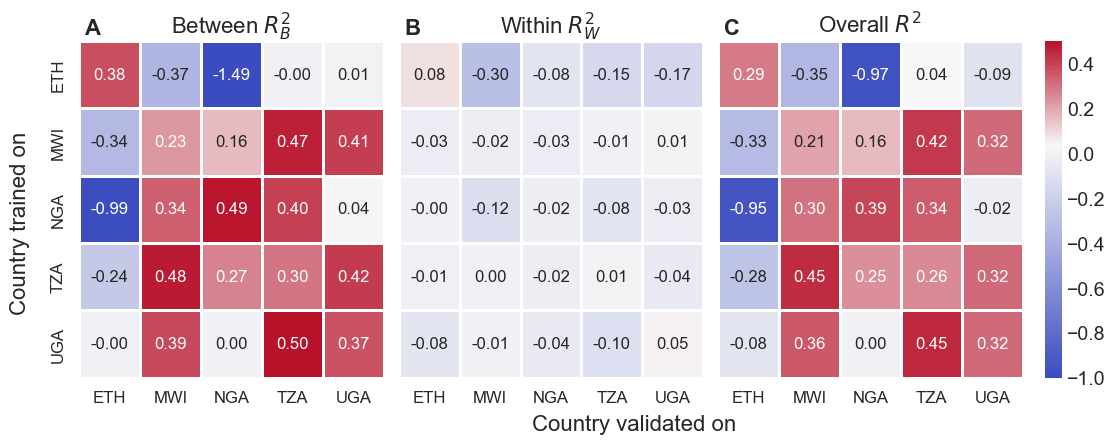

In [258]:
letters =  ['A', 'B', 'C']
sns.set_theme(style="white")

# Create a figure and axis for the plot
fig, axes = plt.subplots(1,3, figsize=(12, 4), sharey = True)

data_between = final_res['between_r2'].astype(float)
data_within = final_res['within_r2'].astype(float)
data_overall = final_res['overall_r2'].astype(float)

colors = ['#3B4CC0', '#F7F7F7', '#B8122A']  # Blue, Gray, Red

# Define the positions for the color transitions
positions = [0, 0.69, 1]  # Corresponding to blue, gray, and red

# Create a colormap with color transitions around 0
cmap = LinearSegmentedColormap.from_list("BlueGrayRed", list(zip(positions, colors)), N=256)

# Define the color map with segmented colors

common_vmin = max(min(data_between.min().min(), data_within.min().min(), data_overall.min().min()),-1)
common_vmax = max(data_between.max().max(), data_within.max().max(), data_overall.max().min())

#cmap = LinearSegmentedColormap.from_list("BlueGrayRed", colors, N=256)


#sns.heatmap(data, cmap='coolwarm', annot=True, fmt='.2f', cbar=True, ax=ax, linewidths=1)

# Create heatmaps for each data frame and place them in the subplots
heatmap_between = sns.heatmap(data_between, cmap=cmap, annot=True, fmt='.2f', cbar=False, ax=axes[0], linewidths=1, vmin=common_vmin, vmax=common_vmax)
heatmap_within = sns.heatmap(data_within, cmap=cmap, annot=True, fmt='.2f', cbar=False, ax=axes[1], linewidths=1, vmin=common_vmin, vmax=common_vmax)
heatmap_overall = sns.heatmap(data_overall, cmap=cmap, annot=True, fmt='.2f', cbar=False, ax=axes[2], linewidths=1, vmin=common_vmin, vmax=common_vmax)

plt.tight_layout()

# cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [x, y, width, height]
# cbar = fig.colorbar(heatmap_overall, cax=cbar_ax)
# Create a common color bar based on vmin and vmax
sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=common_vmin, vmax=common_vmax))
sm.set_array([])  # Dummy empty array for the ScalarMappable

# Add the color bar to the figure
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), pad=0.02)
cbar.ax.tick_params(size=0, labelsize = 14)
cbar.outline.set_visible(False)

# Set titles for each subplot
heatmap_between.set_title('Between $R^2_B$', size = 16)
heatmap_within.set_title('Within $R^2_W$', size = 16)
heatmap_overall.set_title('Overall $R^2$', size = 16)

for ax in axes:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

# add letter to every plot
text_y = 1.02
text_x = 0.02
axes[0].text(text_x, text_y, 'A', transform=axes[0].transAxes, weight='bold', size = 16)
axes[1].text(text_x, text_y, 'B', transform=axes[1].transAxes, weight='bold', size = 16)
axes[2].text(text_x, text_y, 'C', transform=axes[2].transAxes, weight='bold', size = 16)

# Show the plot
fig.text(0.5, -.02, "Country validated on", ha="center", size = 16)
fig.text(-.02, 0.5, "Country trained on", va="center", rotation="vertical", size = 16)
plt.savefig('../figures/results/cross_cntry_validation.png', dpi = 300, bbox_inches='tight')
plt.show()